### Task 3: Polynomial Regression with L1 Regularization
#### **Objective**
In this task, you will implement a class `PolynomialLasso` that fits a polynomial regression model with L1 regularization (Lasso). You will also implement a simple hyperparameter tuning strategy using a validation set.

#### **Conceptual Background**
1.  **Polynomial Regression**: Linear models can fit non-linear data by transforming the input features. For example, if we have a feature $x$, we can create new features $x^2, x^3, \dots, x^d$. A linear model on these expanded features corresponds to a polynomial of degree $d$ on the original features.
2.  **Feature Normalization**: When using Regularization, it is important to scale the features so they have similar ranges (e.g., mean 0, variance 1). Otherwise, features with different ranges will be penalized differently by the objective function.
3.  **Regularization (Lasso)**: L1 regularization adds a penalty term $\alpha \sum |w_i|$ to the loss function, which encourages sparse solutions (driving some coefficients to exactly zero).
4.  **Hyperparameter Tuning**: The strength of regularization is controlled by the hyperparameter $\alpha$. To choose the best $\alpha$, we typically split our training data into a **training set** and a **validation set**. This validation set help us select the best $\alpha$ without overfitting. Notice that this validation set is different from the test set, which is used to evaluate the final model.

---

#### **SubTasks**

##### **SubTask 1: Polynomial Feature Expansion & Scaling**
- **Function**: `_transform_features(self, X)`
- **Goal**: 
    1. Transform the input matrix `X` into polynomial features of degree `self.degree` (use `PolynomialFeatures`).
    2. Normalize the features using `StandardScaler`.
- **Note**: You need to initialize `PolynomialFeatures` and `StandardScaler` if they are not already initialized (training phase), and use the fitted feature transformers otherwise (prediction phase).

##### **SubTask 2: Train-Validation Split**
- **Function**: `_split_data(self, X, y, val_ratio)`
- **Goal**: Split the data into sub-training and validation sets.
- **Requirement**: The validation set should be the **last $n$ rows** of the data, where $n = \text{total\_samples} \times \text{val\_ratio}$. The rest is for training.

##### **SubTask 3: Hyperparameter Tuning (Fit)**
- **Function**: `fit(self, X, y, val_ratio)`
- **Goal**: 
    1. Reset your transformers (`poly` and `scaler`).
    2. Transform features (Expansion + Scaling).
    3. Split data.
    4. Iterate through `self.alphas`.
    5. Train `Lasso` on the sub-training set. (Use `max_iter=100000` to ensure convergence).
    6. Evaluate MSE on the validation set.
    7. Select the best $\alpha$.
    8. **Refit** the model using the best $\alpha$ on the **entire** dataset (all rows).


In [1]:
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error

class PolynomialLasso:
    """
    Polynomial Regression with L1 regularization and validation-based alpha selection.
    """
    
    def __init__(self, degree=2, alphas=[0.1, 1.0, 10.0]):
        self.degree = degree
        self.alphas = alphas
        self.best_alpha = None
        self.best_model = None
        self.min_val_error = float('inf')
        self.poly = None
        self.scaler = None
        
    def _transform_features(self, X):
        """
        Transforms input features X into polynomial features and scales them.
        """
        # TODO: Implement this function
        # 1. Initialize self.poly (if None) and transform X
        # 2. Initialize self.scaler (if None) and scale the poly features
        # Hint: Check if self.poly/self.scaler are None to decide whether to fit_transform or just transform
        # X_scaled = ...

        if self.poly is None:
            from sklearn.preprocessing import PolynomialFeatures
            self.poly = PolynomialFeatures(degree=self.degree, include_bias=False)
            X_poly = self.poly.fit_transform(X)
        else:
            X_poly = self.poly.transform(X)

        if self.scaler is None:
            from sklearn.preprocessing import StandardScaler
            self.scaler = StandardScaler()
            X_scaled = self.scaler.fit_transform(X_poly)
        else:
            X_scaled = self.scaler.transform(X_poly)


        return X_scaled

    def _split_data(self, X, y, val_ratio):
        """
        Splits the data into training and validation sets using the LAST n rows logic.
        """
        # TODO: Implement this function
        # Calculate split index: n_val = total_samples * val_ratio
        total_samples = len(X)
        n_val = int(total_samples * val_ratio)
        split_index = total_samples - n_val
        X_train_sub = X[:split_index]
        y_train_sub = y[:split_index]
        X_val = X[split_index:]
        y_val = y[split_index:]

        return X_train_sub, y_train_sub, X_val, y_val

    def fit(self, X, y, val_ratio=0.2):
        """
        Fits the model with hyperparameter tuning.
        """
        # Reset transformers for new training
        self.poly = None
        self.scaler = None
        
        # 1. Transform features (will fit the feature transformers)

        X_poly = self._transform_features(X)
        
        # 2. Split data

        X_sub ,y_sub ,X_val, y_val = self._split_data(X_poly, y, val_ratio)

        best_alpha = None
        best_mse = float('inf')
        
        # 3. Hyperparameter search
        for alpha in self.alphas:
            # Initialize Lasso
            # Increase max_iter to 100000 to ensure convergence with Coordinate Descent.
            lasso = Lasso(alpha, max_iter=100000)
            
            # Train on sub-training set
            lasso.fit(X_sub, y_sub)
            # Validate on validation set
            y_val_pred = lasso.predict(X_val)
            mse = mean_squared_error(y_val, y_val_pred)
            # Update best_alpha if mse is lower
            if(mse< best_mse):
                min_mse = mse
                best_alpha = alpha


        
        self.best_alpha = best_alpha
        self.best_mse = best_mse

        
        # 4. Refit on ALL data with best alpha
        self.best_model = Lasso(alpha=self.best_alpha, max_iter=100000)
        self.best_model.fit(X_poly, y)
        
    def predict(self, X):
        """
        Predicts using the best fitted model.
        """
        if self.best_model is None:
            raise RuntimeError("Model is not fitted yet.")
            
        # 5. Transform features (will use fitted transformers)
        X_poly = self._transform_features(X)
        return self.best_model.predict(X_poly)


### Verification
Let's test the implementation using the **California Housing** dataset from Scikit-Learn. We will try to predict housing prices based on features like median income, house age, etc. We will inspect performance on both the training and test sets.

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# 1. Load Data
data = fetch_california_housing()
X, y = data.data, data.target

# Print sizes of Train and Test
print(f"Full dataset size: {len(X)}")

# Use a subset for faster demonstration (optional)
X = X[:3000]
y = y[:3000]

# 2. Split into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print sizes of Train and Test
print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}")

# 3. Initialize and Fit
# Note: No manual scaling is needed here as it's handled inside the class
alphas = [0.001, 0.01, 0.1, 1.0]
model = PolynomialLasso(degree=3, alphas=alphas)

print("Training model... (this might take a moment)")
model.fit(X_train, y_train, val_ratio=0.2)

# 5. Evaluate
print(f"Best Alpha: {model.best_alpha}")
print(f"Validation MSE: {model.min_val_error:.4f}")

# Predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Metrics
train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred_test)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print("\nPerformance:")
print(f"Train MSE: {train_mse:.4f} | Train R2: {train_r2:.4f}")
print(f"Test MSE:  {test_mse:.4f} | Test R2:  {test_r2:.4f}")

Full dataset size: 20640
Train size: 2400
Test size: 600
Training model... (this might take a moment)
Best Alpha: 1.0
Validation MSE: inf

Performance:
Train MSE: 0.9107 | Train R2: 0.0000
Test MSE:  0.9519 | Test R2:  -0.0011


### Observation
As an additional observation, let's examine how L1 regularisation affects the learned parameters. To this end, we will compare the histogram of parameter values obtained when training the model with regularisation against those obtained when training a model without regularisation.

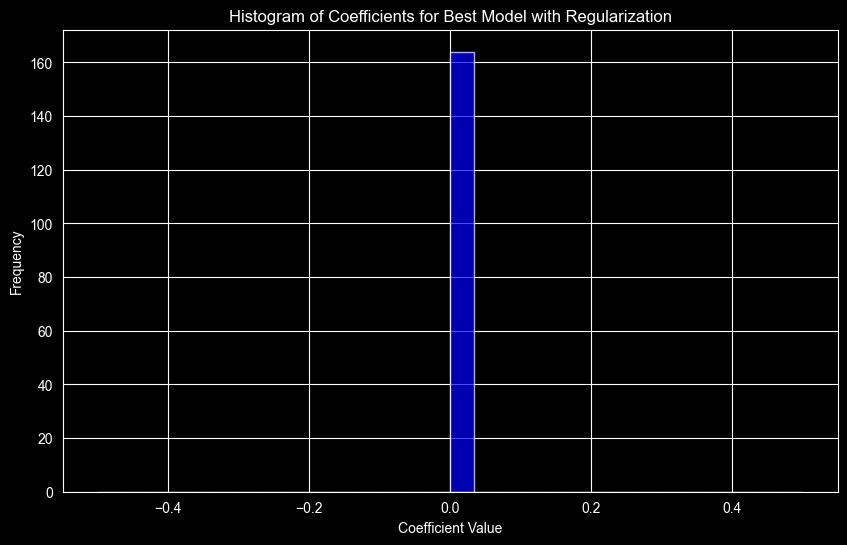

In [3]:
# Let's first plot the coefficients values for the best perfoming regularized model.

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(model.best_model.coef_, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Coefficients for Best Model with Regularization')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

C:\Users\Anu\Lib\site-packages\sklearn\base.py:1336: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\Anu\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anu\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e+02, tolerance: 1.740e-01
Linear regression models with a zero l1 penalization strength are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Anu\Lib\site-packages\sklea

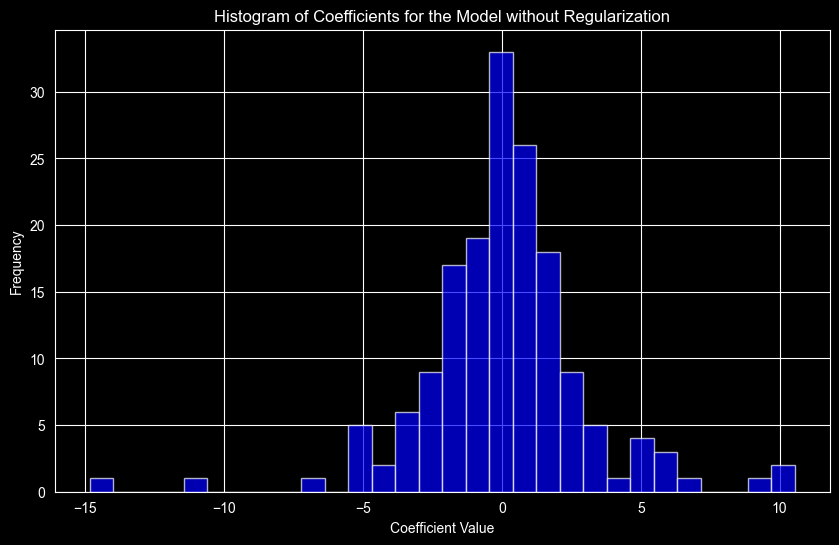

In [4]:
# Let's now plot the coefficient of the parameters for the model without regularization. (Note: To do this we will train a Lasso regression with alpha equal to zero. This is not the most efficient way to numerically perform the task, but it is the most convinient in the context of this exercise.)

model_not_regularized = PolynomialLasso(degree=3, alphas=[0.00])
model_not_regularized.fit(X_train, y_train, val_ratio=0.2)
plt.figure(figsize=(10, 6))
plt.hist(model_not_regularized.best_model.coef_, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Coefficients for the Model without Regularization')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()